## Previsão do PLD através de Xgboost

### Monica Barros
### Data; 21/06/2018

In [166]:
library(readxl)
library(magrittr)
library(caret)
library(lubridate)

library(tidyverse)

library(repr) # Permite mudar o tamanho das figuras dentro do Jupyter Notebook

library(gbm)

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


In [7]:
path_root <- file.path("/home/monica/monica_files") 
path_code <- file.path(path_root, "PROGRAMAS R")
path_data <- file.path(path_root, "MIND - Assinaturas")
setwd(path_data)

### Leitura dos dados

In [10]:
df = readxl::read_excel("PLD_200107_201806.xls")

In [11]:
head(df)

Ano,Mês,Semana,Data Início,Data Fim,Pesado SE,Médio SE,Leve SE,Pesado S,Médio S,Leve S,Pesado NE,Médio NE,Leve NE,Pesado N,Médio N,Leve N
2001,7,1,2001-06-30,2001-07-06,684,684,684,141.61,141.61,141.61,684,684,684,684,684,684
2001,7,2,2001-07-07,2001-07-13,684,684,684,4.00,4.00,4.00,684,684,684,684,684,684
2001,7,3,2001-07-14,2001-07-20,684,684,684,4.00,4.00,4.00,684,684,684,684,684,684
2001,7,4,2001-07-21,2001-07-27,684,684,684,86.94,86.94,86.94,684,684,684,684,684,684
2001,8,1,2001-07-28,2001-08-03,684,684,684,37.12,37.12,37.12,684,684,684,684,684,684
2001,8,2,2001-08-04,2001-08-10,684,684,684,4.00,4.00,4.00,684,684,684,684,684,684


In [12]:
tail(df)

Ano,Mês,Semana,Data Início,Data Fim,Pesado SE,Médio SE,Leve SE,Pesado S,Médio S,Leve S,Pesado NE,Médio NE,Leve NE,Pesado N,Médio N,Leve N
2018,5,3,2018-05-12,2018-05-18,333.78,333.78,313.62,333.78,333.78,313.62,165.95,165.95,165.95,116.25,116.25,112.53
2018,5,4,2018-05-19,2018-05-25,348.43,348.43,327.41,348.43,348.43,327.41,201.88,201.88,201.88,201.88,201.88,201.88
2018,6,1,2018-05-26,2018-06-01,418.96,418.96,380.59,418.96,418.96,380.59,380.83,380.83,380.59,380.83,380.83,380.59
2018,6,2,2018-06-02,2018-06-08,457.54,457.54,411.94,457.54,457.54,411.94,321.06,321.06,321.06,321.06,321.06,321.06
2018,6,3,2018-06-09,2018-06-15,482.29,480.00,457.87,482.29,480.00,457.87,466.74,466.74,457.87,466.74,466.74,457.87
2018,6,4,2018-06-16,2018-06-22,485.85,485.85,463.60,485.85,485.85,463.60,485.85,485.85,463.60,485.85,485.85,463.60


### Considerar apenas os patamares médios

In [75]:
df_med = df[,c(1:5,7,10,13,16)]

In [76]:
tail(df_med)

Ano,Mês,Semana,Data Início,Data Fim,Médio SE,Médio S,Médio NE,Médio N
2018,5,3,2018-05-12,2018-05-18,333.78,333.78,165.95,116.25
2018,5,4,2018-05-19,2018-05-25,348.43,348.43,201.88,201.88
2018,6,1,2018-05-26,2018-06-01,418.96,418.96,380.83,380.83
2018,6,2,2018-06-02,2018-06-08,457.54,457.54,321.06,321.06
2018,6,3,2018-06-09,2018-06-15,480.00,480.00,466.74,466.74
2018,6,4,2018-06-16,2018-06-22,485.85,485.85,485.85,485.85


### Script para criar lags das variáveis e transformar Ano, Mês, Semana em fatores

In [110]:
df_med <- df_med %>% dplyr::mutate(pld_se_lag1 = dplyr::lag(df_med$'Médio SE'),
                             pld_se_lag2 = dplyr::lag(pld_se_lag1),
                             pld_se_lag3 = dplyr::lag(pld_se_lag2),
                             pld_se_lag4 = dplyr::lag(pld_se_lag3), 
                             pld_se_lag5 = dplyr::lag(pld_se_lag4),
                             pld_se_lag6 = dplyr::lag(pld_se_lag5),
                             pld_se_lag7 = dplyr::lag(pld_se_lag6),
                             pld_se_lag8 = dplyr::lag(pld_se_lag7),
                             pld_s_lag1 = dplyr::lag(df_med$'Médio S'),
                             pld_s_lag2 = dplyr::lag(pld_s_lag1),
                             pld_s_lag3 = dplyr::lag(pld_s_lag2),
                             pld_s_lag4 = dplyr::lag(pld_s_lag3),
                             pld_s_lag5 = dplyr::lag(pld_s_lag4),
                             pld_s_lag6 = dplyr::lag(pld_s_lag5),
                             pld_s_lag7 = dplyr::lag(pld_s_lag6),
                             pld_s_lag8 = dplyr::lag(pld_s_lag7),
                             pld_NE_lag1 = dplyr::lag(df_med$'Médio NE'),
                             pld_NE_lag2 = dplyr::lag(pld_NE_lag1),
                             pld_NE_lag3 = dplyr::lag(pld_NE_lag2),
                             pld_NE_lag4 = dplyr::lag(pld_NE_lag3), 
                             pld_NE_lag5 = dplyr::lag(pld_NE_lag4),
                             pld_NE_lag6 = dplyr::lag(pld_NE_lag5),
                             pld_NE_lag7 = dplyr::lag(pld_NE_lag6),
                             pld_NE_lag8 = dplyr::lag(pld_NE_lag7),
                             pld_N_lag1 = dplyr::lag(df_med$'Médio N'),
                             pld_N_lag2 = dplyr::lag(pld_N_lag1),
                             pld_N_lag3 = dplyr::lag(pld_N_lag2),
                             pld_N_lag4 = dplyr::lag(pld_N_lag3),
                             pld_N_lag5 = dplyr::lag(pld_N_lag4),
                             pld_N_lag6 = dplyr::lag(pld_N_lag5),
                             pld_N_lag7 = dplyr::lag(pld_N_lag6),
                             pld_N_lag8 = dplyr::lag(pld_N_lag7), 
                             Ano = factor(Ano),
                             Mês = factor(Mês),
                             Semana = factor(Semana)
                                  )

In [111]:
glimpse(df_med)

Observations: 893
Variables: 41
$ Ano           <fct> 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001,...
$ Mês           <fct> 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10...
$ Semana        <fct> 1, 2, 3, 4, 1, 2, 3, 4, 5, 1, 2, 3, 4, 1, 2, 3, 4, 1,...
$ `Data Início` <dttm> 2001-06-30, 2001-07-07, 2001-07-14, 2001-07-21, 2001...
$ `Data Fim`    <dttm> 2001-07-06, 2001-07-13, 2001-07-20, 2001-07-27, 2001...
$ `Médio SE`    <dbl> 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684...
$ `Médio S`     <dbl> 141.61, 4.00, 4.00, 86.94, 37.12, 4.00, 37.12, 60.62,...
$ `Médio NE`    <dbl> 684.00, 684.00, 684.00, 684.00, 684.00, 684.00, 684.0...
$ `Médio N`     <dbl> 684, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684...
$ pld_se_lag1   <dbl> NA, 684, 684, 684, 684, 684, 684, 684, 684, 684, 684,...
$ pld_se_lag2   <dbl> NA, NA, 684, 684, 684, 684, 684, 684, 684, 684, 684, ...
$ pld_se_lag3   <dbl> NA, NA, NA, 684, 684, 684, 684, 684, 684, 684, 684, 6...
$ pld_se_lag4   <dbl

### Converter dados para o tipo "ts" (série temporal)

In [112]:
ts_data = ts(df_med,  freq = 365.25/7, start = lubridate::decimal_date(ymd("2001-06-30")))

In [113]:
str(ts_data)

 Time-Series [1:893, 1:41] from 2001 to 2019: 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:41] "Ano" "Mês" "Semana" "Data Início" ...


In [114]:
tail(ts_data[,'Médio SE'])

[1] 333.78 348.43 418.96 457.54 480.00 485.85

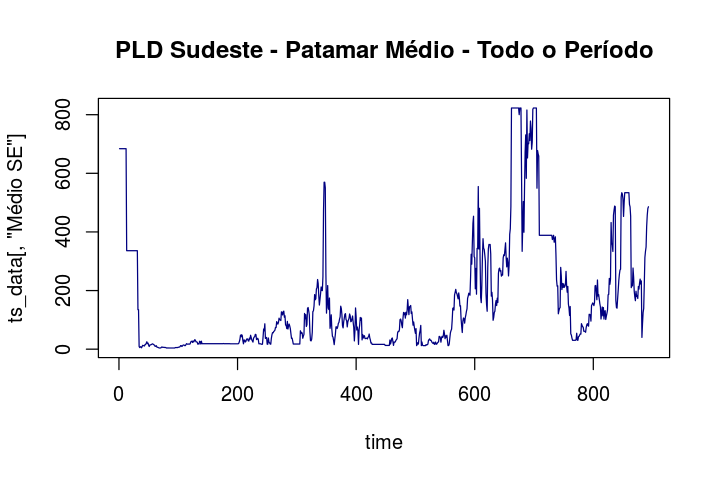

In [115]:
options(repr.plot.width = 6, repr.plot.height = 4)
time=1:NROW(ts_data[,'Médio SE'])
            
plot(time,ts_data[,'Médio SE'], type ="l", col = "navy", 
           main = "PLD Sudeste - Patamar Médio - Todo o Período")

### Criar objeto contendo apenas os dados do Sudeste

### Separar os dados em treinamento e teste

In [183]:
df_SE <-  df_med %>% as.data.frame() %>% dplyr::select(-c(4,5,7,8,9, 18:41)) #%>% 
                    #ts(., freq = 365.25/7, start = lubridate::decimal_date(ymd("2001-06-30"))) 

In [184]:
train_percentage = 75/100  # Define o percentual dos dados usados no treinamento

#### Período de Treinamento

In [185]:
dst_train = df_SE[1:floor(train_percentage*NROW(df_SE)),] 

In [186]:
tail(dst_train,3)

,Ano,Mês,Semana,Médio SE,pld_se_lag1,pld_se_lag2,pld_se_lag3,pld_se_lag4,pld_se_lag5,pld_se_lag6,pld_se_lag7,pld_se_lag8
667,2014,3,2,822.83,822.83,822.83,822.83,822.83,822.83,486.59,410.67,391.80
668,2014,3,3,822.83,822.83,822.83,822.83,822.83,822.83,822.83,486.59,410.67
669,2014,3,4,822.83,822.83,822.83,822.83,822.83,822.83,822.83,822.83,486.59


#### Período de Teste

In [187]:
dst_test=df_SE[(floor(0.75*NROW(ts_data))+1):NROW(ts_data),]

In [188]:
head(dst_test,3)

,Ano,Mês,Semana,Médio SE,pld_se_lag1,pld_se_lag2,pld_se_lag3,pld_se_lag4,pld_se_lag5,pld_se_lag6,pld_se_lag7,pld_se_lag8
670,2014,4,1,822.83,822.83,822.83,822.83,822.83,822.83,822.83,822.83,822.83
671,2014,4,2,822.83,822.83,822.83,822.83,822.83,822.83,822.83,822.83,822.83
672,2014,4,3,822.83,822.83,822.83,822.83,822.83,822.83,822.83,822.83,822.83


In [189]:
tail(dst_test,3)

,Ano,Mês,Semana,Médio SE,pld_se_lag1,pld_se_lag2,pld_se_lag3,pld_se_lag4,pld_se_lag5,pld_se_lag6,pld_se_lag7,pld_se_lag8
891,2018,6,2,457.54,418.96,348.43,333.78,312.82,222.50,138.72,125.33,87.61
892,2018,6,3,480.00,457.54,418.96,348.43,333.78,312.82,222.50,138.72,125.33
893,2018,6,4,485.85,480.00,457.54,418.96,348.43,333.78,312.82,222.50,138.72


### Definir a estrutura do modelo

In [190]:
model_struc = as.formula("dst_train[,'Médio SE'] ~ .")

In [191]:
str(dst_train)

'data.frame':	669 obs. of  12 variables:
 $ Ano        : Factor w/ 18 levels "2001","2002",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Mês        : Factor w/ 12 levels "1","2","3","4",..: 7 7 7 7 8 8 8 8 8 9 ...
 $ Semana     : Factor w/ 5 levels "1","2","3","4",..: 1 2 3 4 1 2 3 4 5 1 ...
 $ Médio SE   : num  684 684 684 684 684 684 684 684 684 684 ...
 $ pld_se_lag1: num  NA 684 684 684 684 684 684 684 684 684 ...
 $ pld_se_lag2: num  NA NA 684 684 684 684 684 684 684 684 ...
 $ pld_se_lag3: num  NA NA NA 684 684 684 684 684 684 684 ...
 $ pld_se_lag4: num  NA NA NA NA 684 684 684 684 684 684 ...
 $ pld_se_lag5: num  NA NA NA NA NA 684 684 684 684 684 ...
 $ pld_se_lag6: num  NA NA NA NA NA NA 684 684 684 684 ...
 $ pld_se_lag7: num  NA NA NA NA NA NA NA 684 684 684 ...
 $ pld_se_lag8: num  NA NA NA NA NA NA NA NA 684 684 ...


In [ ]:
### USAR ONE HOT ENCODING - PODE SER QUE O PROBLEMA ESTEJA NA CV, FOLDS QUE NÃO ETM OS DADOS

In [192]:
tic = Sys.time()

set.seed(123) 

gbm1 <- gbm(formula = model_struc, distribution = "gaussian",
            n.trees =  1000, # c(5000, 7500, 10000)
            interaction.depth = 3,
            n.minobsinnode = 2, #c(1,2)
            shrinkage = 0.01,
            cv.folds = 2,
            data = dst_train_small, keep.data = FALSE,
            n.cores = NULL) # Para usar todos os "cores" disponíveis na máquina
best.iter <- gbm.perf(gbm1, method="cv", plot=FALSE)

toc = Sys.time()

delta_t = toc - tic  # Computa o tempo decorrido

ERROR: Error in x[, i]: subscript out of bounds


In [ ]:
print(paste0("Tempo necessário para rodar GBM: " , round(delta_t,2)))

In [ ]:
# print model
print(gbm1) 

In [ ]:
# check performance using 5-fold cross-validation
options(repr.plot.width = 10, repr.plot.height = 5)
best.iter <- gbm.perf(gbm1,method="cv")

In [ ]:
# summary - Gradient Boosting Machine - variables in descending order of importance
summary(gbm1)

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)
# check variable importance
f_imp <- summary(gbm1, n.trees = best.iter, plot = FALSE) 
# use a custom plot to show variable importance

# Show first 20 variables only
barplot(f_imp$rel.inf[1:20], names.arg = f_imp$var[1:20], xlab = "Feature", ylab = "Relative influence", las = 2, cex.names = 0.7, col=c("darkblue"))

In [ ]:
# Top 20 variables and their relative importances
head(f_imp,20)

In [ ]:
# Define prediction function
predict_gbm <- function(newdata)
{
  require(gbm)
  predict(gbm1, newdata, best.iter)
}

In [ ]:
# test the prediction function
newdata <- dst_test_small
pred <- predict_gbm(dst_test_small)
actual = dst_test_small$Price_Medium

In [ ]:
perc_error = round(100*((actual-pred)/actual), digits = 3)
abs_perc_error = abs(perc_error)
result_test_period = data.frame(actual, forecast = pred, perc_error, abs_perc_error);

In [ ]:
MAPE = function(real, pred){
    y = 100 * mean(abs((real-pred)/real), na.rm = TRUE)
    return(y)
    }

In [ ]:
print(paste0("MAPE = ", round(MAPE(actual,pred),4)))

In [ ]:
head(result_test_period)

In [ ]:
tail(result_test_period)

In [ ]:
time=1:nrow(result_test_period)
plot(time,abs_perc_error, type ="l", col = "red", main = "GBM Forecast - Absolute % Error - Test Period")

In [ ]:
# Histogram of Absolute Percentage Errors 
options(repr.plot.width = 5, repr.plot.height = 5)
hist(perc_error, main = "GBM - Distribution of % Errors", col = "green", xlab = NULL, breaks = seq(-300,300,20))

In [ ]:
# Histogram of Absolute Percentage Errors 
options(repr.plot.width = 5, repr.plot.height = 5)
hist(abs_perc_error, main = "GBM - Distribution of Absolute % Errors", col = "red", xlab = NULL, breaks = seq(0,300,20))

In [ ]:
MAPE = mean(abs_perc_error)
print(paste0("MAPE = ", round(MAPE,4)))

In [ ]:
print(paste0("Minimum % Error (test period): ", min(perc_error, na.rm = TRUE)))

In [ ]:
print(paste0("Maximum  % Error (test period): ",max(perc_error, na.rm = TRUE)))

In [ ]:
head(result_test_period)

In [ ]:
summary(perc_error)

In [ ]:
library(ggplot2)
options(repr.plot.width = 10, repr.plot.height = 5)
ggplot(result_test_period, aes(x = actual, y = forecast)) + 
    geom_point(colour = "blue", alpha = 0.5) +
    stat_smooth(colour = "red") + 
    ggtitle("GBM prediction of Spot Price (medium load)- Test Period")

In [ ]:
rtp = rtp=cbind(result_test_period,dst_test[,c(1,2,3,8,9,10)])  # Contains results and date/time information - will be useful in plotting

In [ ]:
head(rtp)

In [ ]:
# Finding the rows with absolute % errors above 30%
subset(rtp, abs_perc_error > 30)

In [ ]:
# Finding the number of rows with absolute % errors above 10%, 20%, 30%

print(paste0(" GBM - Number of forecasts with abs. error > 10%: ",nrow(subset(rtp, abs_perc_error > 10))))
print(paste0(" GBM - Number of forecasts with abs. error > 20%: ",nrow(subset(rtp, abs_perc_error > 20))))
print(paste0(" GBM - Number of forecasts with abs. error > 30%: ",nrow(subset(rtp, abs_perc_error > 30))))

In [ ]:
ggplot(rtp, aes(x = Month, y = abs_perc_error)) + geom_boxplot(colour = "navy", fill = "blanchedalmond") + ggtitle("Box-Plot of ABSOLUTE Percentage Errors - GBM prediction")

In [ ]:
ggplot(rtp, aes(x = Year, y = perc_error)) + geom_boxplot(colour = "coral2", fill = "bisque2") + ggtitle("Box-Plot of Percentage Errors - GBM prediction")

In [ ]:
ggplot(rtp, aes(x = Year, y = abs_perc_error)) + geom_boxplot(colour = "navy", fill = "bisque2") + ggtitle("Box-Plot of ABSOLUTE Percentage Errors - GBM prediction")